# 1. Installing and Importing Dependencies

In [ ]:
# !pip install pyglet

In [ ]:
!pip install gym[box2d]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install pygame 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!apt-get install x11-utils > /dev/null 2>&1 
!pip install pyglet > /dev/null 2>&1 
!apt-get install -y xvfb python-opengl > /dev/null 2>&1

In [ ]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1

In [ ]:
!pip install git+https://github.com/DLR-RM/stable-baselines3#egg=stable-baselines3[extra]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/DLR-RM/stable-baselines3 to /tmp/pip-install-kya4po5j/stable-baselines3_1c10614c9c984f5d97b4e52f6a1948d5
  Running command git clone -q https://github.com/DLR-RM/stable-baselines3 /tmp/pip-install-kya4po5j/stable-baselines3_1c10614c9c984f5d97b4e52f6a1948d5


In [ ]:
!pip install gym==0.24.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached gym-0.24.1-py3-none-any.whl
  Attempting uninstall: gym
    Found existing installation: gym 0.21.0
    Uninstalling gym-0.21.0:
      Successfully uninstalled gym-0.21.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
stable-baselines3 1.6.1a0 requires gym==0.21, but you have gym 0.24.1 which is incompatible.


In [ ]:
import gym
from gym.spaces import Box, Discrete
from gym.wrappers import FrameStack
from matplotlib import pyplot as plt
import os
os.environ['SDL_VIDEODRIVER']='dummy'
import pygame
pygame.display.set_mode((640,480))
gym.__version__

'0.24.1'

In [ ]:
import torch
from torch import nn
from torchvision import transforms as T
from PIL import Image
from matplotlib import cm
import numpy as np
from pathlib import Path
from collections import deque
import random, datetime, copy

In [ ]:
# Change working directory
from google.colab import drive
drive.mount('/content/drive')

os.chdir('/content/drive/MyDrive/SUTD/AI Lab')
print(os.getcwd())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/SUTD/AI Lab


# 2. Loading the environment

In [ ]:
env = gym.make('CarRacing-v1')

/usr/local/lib/python3.7/dist-packages/gym/utils/passive_env_checker.py:98: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  "We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) "


In [ ]:
obs_space = env.observation_space
action_space = env.action_space
print("The observation space: {}".format(obs_space))
print("The action space: {}".format(action_space))
print("The action space is bounded: {}".format(action_space.is_bounded()))
print("The action space Upper Bound: {}".format(action_space.high))
print("The action space Lower Bound: {}".format(action_space.low))

The observation space: Box(0, 255, (96, 96, 3), uint8)
The action space: Box([-1.  0.  0.], 1.0, (3,), float32)
The action space is bounded: True
The action space Upper Bound: [1. 1. 1.]
The action space Lower Bound: [-1.  0.  0.]


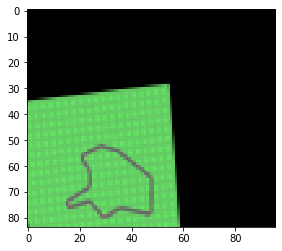

In [ ]:
#Lets take a look at our environment
obs = env.reset()
plt.imshow(obs[:-12], interpolation='nearest')
plt.show()

[0.4236744  0.20175415 0.93572897]
6.289776357827477 False {}


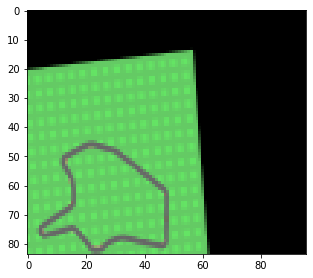

In [ ]:
# Sample a random action from the entire action space
random_action = env.action_space.sample()
print(random_action)
# Take the action and get the new observation space
new_obs, reward, done, info = env.step(random_action)
print(reward, done, info)
plt.figure(figsize=(5,5))
plt.imshow(new_obs[:-12], interpolation='nearest')
plt.show()

# 3. Wrappers

## Observation Wrappers

In [ ]:
import cv2
class GrayScaleObservation(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        obs_shape = self.observation_space.shape[:2]
        self.observation_space = Box(low=0, high=255, shape=obs_shape, dtype=np.uint8)

    def permute_orientation(self, observation):
        # permute [H, W, C] array to [C, H, W] tensor
        observation = np.transpose(observation, (2, 0, 1))
        observation = torch.tensor(observation.copy(), dtype=torch.float)
        return observation

    def observation(self, observation):
        # observation = self.permute_orientation(observation)
        transform = T.Grayscale()
        observation = transform(observation)
        return observation

# class ObservationWrapper(gym.ObservationWrapper):
#     def __init__(self, env):
#         super().__init__(env)
    
#     def observation(self, obs):
#         # Normalise observation by 255
#         return obs / 255.0

class ObservationWrappers(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        obs_shape = self.observation_space.shape[:2]
        self.observation_space = Box(low=0, high=255, shape=obs_shape, dtype=np.uint8)
        self.frames = []

    def permute_orientation(self, observation):
        # permute [H, W, C] array to [C, H, W] tensor
        observation = np.transpose(observation, (2, 0, 1))
        observation = torch.tensor(observation.copy(), dtype=torch.float)
        return observation

    def blur_image(self, observation):
        blur = cv2.GaussianBlur(observation, (5, 5), 0)
        return blur

    def observation(self, observation):
        cropped = observation[:-12]
        cropped = cv2.copyMakeBorder(cropped, 0, 12, 0, 0, cv2.BORDER_CONSTANT, value=[0, 0, 0])
        gray = cv2.cvtColor(cropped, cv2.COLOR_RGB2GRAY)
        blur = self.blur_image(gray)
        canny = self.canny_edge_detector(blur)

        self.frames.append(canny)
        return canny

    def canny_edge_detector(self, observation):
        canny = cv2.Canny(observation, 50, 150)
        return canny

    def generate_video(self):
        print("generating video")
        fourcc = cv2.VideoWriter_fourcc("M", "J", "P", "G")
        self.video = cv2.VideoWriter("./video.avi", fourcc, 20, (17, 49))

        for i in range(len(self.frames)):
            self.video.write(self.frames[i])
        self.video.release()

class ResizeObservation(gym.ObservationWrapper):
    def __init__(self, env, shape):
        super().__init__(env)
        if isinstance(shape, int):
            self.shape = (shape, shape)
        else:
            self.shape = tuple(shape)

        obs_shape = self.shape + self.observation_space.shape[2:]
        self.observation_space = Box(low=0, high=255, shape=obs_shape, dtype=np.uint8)

    def permute_orientation(self, observation):
        # permute [H, W, C] array to [C, H, W] tensor
        observation = np.transpose(observation, (2, 0, 1))
        observation = torch.tensor(observation.copy(), dtype=torch.float)
        return observation

    def observation(self, observation):
        transforms = T.Compose(
            [T.Resize(self.shape), T.Normalize(0, 255)]
        )
        observation = self.permute_orientation(observation)
        observation = transforms(observation).squeeze(0)
        return observation

### Example of using observation wrappers

[0.39216   0.824331  0.3637444]
6.269426751592357 False {}


/usr/local/lib/python3.7/dist-packages/gym/utils/passive_env_checker.py:98: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  "We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) "


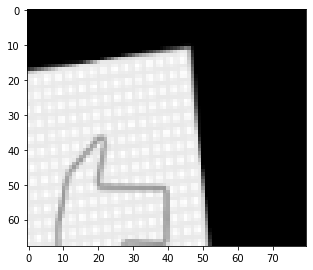

In [ ]:
env = gym.make('CarRacing-v1')
env.reset()
env = GrayScaleObservation(ResizeObservation(env, (80,80)))

random_action = env.action_space.sample()
print(random_action)
# Take the action and get the new observation space
new_obs, reward, done, info = env.step(random_action)

print(reward, done, info)
plt.figure(figsize=(5,5))
plt.imshow(new_obs[0,:,:][:-12], cmap='gray',interpolation='nearest')
plt.show()

## Reward Wrappers

In [ ]:
class RewardWrapper(gym.RewardWrapper):
    def __init__(self, env):
        super().__init__(env)
    
    def reward(self, reward):
        # Clip reward between 0 to 1
        print(reward)
        return np.clip(reward, 0, 1)

## Action Wrappers
Map actions to discrete spaces.

Reason: Suppose you want to train a (D)DQN agent for an environment with continuous actions. Since DQN implementations typically expect to produce a single discrete action, the action space has to both be discretized and flattened.

In [ ]:
class ActionWrapper(gym.ActionWrapper):
    def __init__(self, env):
        super().__init__(env)
    
    def action(self, act):
        print(act)
        return act

class DiscreteWrapper(gym.Wrapper):
    def __init__(self, env):
        super().__init__(env)
        self.env = env
        self.__actions__ = [(-1, 0.2, 0.), (0, 0.2, 0.), (1, 0.2, 0.),
                            (-1, 0.5, 0.), (0, 0.5, 0.), (1, 0.5, 0.), #           Action Space Structure
                            (-1, 1,   0), (0, 1,   0), (1, 1,   0), #        (Steering Wheel, Gas, Break)
                            (-1, 0, 0.8), (0, 0, 0.8), (1, 0, 0.8), # Range        -1~1       0~1   0~1
                            (-1, 0, 0.3), (0, 0, 0.3), (1, 0, 0.3),
                            (-1, 0,   0), (0, 0,   0), (1, 0,   0)]

        
        self.action_space = Discrete(len(self.__actions__)-1)
        
    def step(self, action):
        # print(action)
        next_state, reward, done, info = self.env.step(self.__actions__[action])
        # modify ...
        return next_state, reward, done, info

### Example of using action wrappers

15
7.592307692307693 False {}


/usr/local/lib/python3.7/dist-packages/gym/utils/passive_env_checker.py:98: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  "We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) "


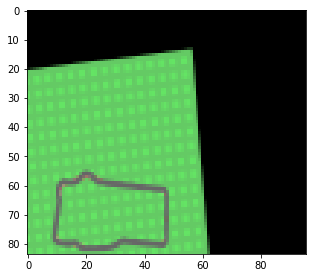

In [ ]:
env = gym.make('CarRacing-v1')
env.reset()
env = DiscreteWrapper(env)

random_action = env.action_space.sample()
print(random_action)
# Take the action and get the new observation space
new_obs, reward, done, info = env.step(random_action)

print(reward, done, info)
plt.figure(figsize=(5,5))
plt.imshow(new_obs[:-12], cmap='gray',interpolation='nearest')
plt.show()

## Other Wrappers

In [ ]:
class SkipFrame(gym.Wrapper):
    def __init__(self, env, skip):
        """Return only every `skip`-th frame"""
        super().__init__(env)
        self._skip = skip

    def step(self, action):
        """Repeat action, and sum reward"""
        total_reward = 0.0
        done = False
        for i in range(self._skip):
            # Accumulate reward and repeat the same action
            obs, reward, done, info = self.env.step(action)
            total_reward += reward
            if done:
                break
        return obs, total_reward, done, info

**Vectorized Environments** are a method for stacking multiple independent environments into a single environment. **Instead of training an RL agent on 1 environment per step**, it allows us to **train it on n environments per step**. Because of this, actions passed to the environment are now a vector (of dimension n). It is the same for observations, rewards and end of episode signals (dones). In the case of non-array observation spaces such as Dict or Tuple, where different sub-spaces may have different shapes, the sub-observations are vectors (of dimension n).

In [ ]:
class VectorizedEnvWrapper(gym.Wrapper):
    def __init__(self, make_env, num_envs=1):
        super().__init__(make_env())
        self.num_envs = num_envs
        self.envs = [make_env() for env_index in range(num_envs)]
    
    def reset(self):
        return np.asarray([env.reset() for env in self.envs])
    
    def reset_at(self, env_index):
        return self.envs[env_index].reset()
    
    def step(self, actions):
        next_states, rewards, dones, infos = [], [], [], []
        for env, action in zip(self.envs, actions):
            next_state, reward, done, info = env.step(action)
            next_states.append(next_state)
            rewards.append(reward)
            dones.append(done)
            infos.append(info)
        return np.asarray(next_states), np.asarray(rewards), \
            np.asarray(dones), np.asarray(infos)

### Example of using Vec Env

/usr/local/lib/python3.7/dist-packages/gym/utils/passive_env_checker.py:98: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  "We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) "


(3, 96, 96, 3)
(3,)
(3,)


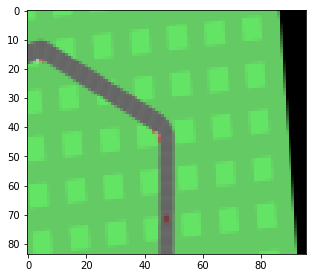

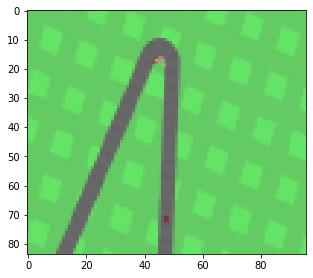

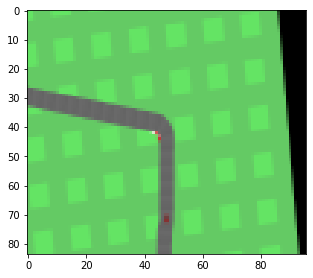

In [ ]:
# Example on how Vec Env is used Vec Env
env = VectorizedEnvWrapper(lambda: gym.make('CarRacing-v1'), 3)

T = 10
observations = env.reset()
for t in range(T):
    actions = []
    for i in range(3):
      actions.append(env.action_space.sample())

    observations, rewards, dones, infos = env.step(actions)  
    for i in range(len(dones)):
        if dones[i]:
            observations[i] = env.reset_at(i)
print(observations.shape)
print(rewards.shape)
print(dones.shape)

for i in observations:
  plt.figure(figsize=(5,5))
  plt.imshow(i[:-12], interpolation='nearest')
  plt.show()

## Customised env make

In [ ]:
def env_make():
    env = gym.make('CarRacing-v1')
    env = SkipFrame(env, 2)
    env = ObservationWrappers(env)
    env = DiscreteWrapper(env) #discretize actions
    # env = FrameStack(env, num_stack=2)
    return env

# Train an RL Model

In [ ]:
from stable_baselines3 import PPO, DQN
from stable_baselines3.common.evaluation import evaluate_policy
env = env_make()
# env = DummyVecEnv([lambda: env]) # Wrapper for a non-vectorized environment
model = DQN("MlpPolicy",
            env,
            verbose=1,
            train_freq=16,
            gradient_steps=8,
            gamma=0.99,
            exploration_fraction=0.2,
            exploration_final_eps=0.07,
            target_update_interval=600,
            learning_starts=1000,
            buffer_size=10000,
            batch_size=128,
            learning_rate=4e-3,
            policy_kwargs=dict(net_arch=[256, 256]),
            seed=2)

/usr/local/lib/python3.7/dist-packages/gym/utils/passive_env_checker.py:98: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  "We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) "
/usr/local/lib/python3.7/dist-packages/gym/core.py:201: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  "Function `env.seed(seed)` is marked as deprecated and will be removed in the future. "


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [ ]:
models_dir = "./DQN"
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

TIMESTEPS = 10000 # The number of env steps for each epoch
epochs = 20  # Number of training iterations

for i in range(1,epochs):
  model.learn(total_timesteps=TIMESTEPS)
  model.save(f"{models_dir}/{TIMESTEPS*i}")

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 500      |
|    ep_rew_mean      | -52.4    |
|    exploration_rate | 0.07     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 32       |
|    time_elapsed     | 60       |
|    total_timesteps  | 2000     |
| train/              |          |
|    learning_rate    | 0.004    |
|    loss             | 0.202    |
|    n_updates        | 496      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 500      |
|    ep_rew_mean      | -55.8    |
|    exploration_rate | 0.07     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 33       |
|    time_elapsed     | 117      |
|    total_timesteps  | 4000     |
| train/              |          |
|    learning_rate    | 0.004    |
|    loss             | 0.151    |
|    n_updates      

# 4. Save and Reload Model

In [ ]:
model.save(f"{models_dir}/{TIMESTEPS*i}")

In [ ]:
model = DQN.load(f"{models_dir}/{TIMESTEPS*i}", env=env)

In [ ]:
model.learn(total_timesteps=20000)

# 5. Evaluation

In [ ]:
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()

# We can review the training performance for 10 episodes
num_steps=10
prev_screen = env.render(mode='rgb_array')
plt.imshow(prev_screen)

for ep in range(num_steps):
    screen = env.render(mode='rgb_array')
    plt.imshow(screen)
    ipythondisplay.clear_output(wait=True)
    ipythondisplay.display(plt.gcf())

    done = False
    while not done:
        screen = env.render(mode='rgb_array')
        plt.imshow(screen)
        ipythondisplay.clear_output(wait=True)
        ipythondisplay.display(plt.gcf())
        obs, reward, done, info = env.step(env.action_space.sample())

env.close()

In [ ]:
evaluate_policy(model, env, n_eval_episodes=10, render=True)

# 6. Test Model

In [ ]:
episodes = 5 
for episode in range(1, episodes+1):
  obs = env.reset()
  # gives the initial observation for the environment 
  
  done = False
  score = 0

  while not done:
    env.render()
    action , _ = model.predict(obs) # Now USING MODEL HERE!
    obs, reward, done, info = env.step(action)
    score += reward
  print ("Episode: {} Score: {}".format(episode, score))

env.close()